In [21]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [22]:
%env MIX6_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/mix6

env: MIX6_DATASETS=/runai-ivrl-scratch/students/2021-fall-sp-jellouli/mix6


<IPython.core.display.Javascript object>

In [23]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


<IPython.core.display.Javascript object>

In [24]:
# Setup path
import os
import sys

sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.normpath(os.path.join(os.getcwd(), "..", "external", "MiDaS")))

<IPython.core.display.Javascript object>

In [25]:
# These are the available datasets from Mix6
from midas_hkrm.datasets import (
    ApolloScape,
    HRWSI,
    RedWeb,
    BlendedMVS,
    MegaDepth,
    TartanAir,
)
from midas_hkrm.utils import midas_test_transform, setup_logger

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from midas_hkrm.depth import create_midas_hkrm_model

plt.rcParams.update(
    {
        "font.size": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "image.cmap": "plasma",
        "figure.dpi": 100,
    }
)

from midas.midas_net import MidasNet
import logging
from midas_hkrm.zero_shot import MaskedRMSE
import pickle
import os

logger = logging.getLogger()
setup_logger()

<IPython.core.display.Javascript object>

In [26]:
MIDAS_HKRM_V4_WEIGHTS = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output_midas_hkrm_v4/state_299999.tar"
MIDAS_BASELINE_WEIGHTS = "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output_midas_obj_baseline/state_299999.tar"
HKRM_WEIGHTS = (
    "/runai-ivrl-scratch/students/2021-fall-sp-jellouli/output/model_final.pth"
)

<IPython.core.display.Javascript object>

In [91]:
midas_hkrm_v4 = create_midas_hkrm_model(
    15,
    0.4,
    midas_hkrm_weights=torch.load(MIDAS_HKRM_V4_WEIGHTS)["model"],
    object_model_weights=HKRM_WEIGHTS,
)

INFO:midas_hkrm.depth.midas_hkrm:Creating hkrm based network
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /runai-ivrl-scratch/students/2021-fall-sp-jellouli/output/model_final.pth ...


Using cache found in /runai-ivrl-scratch/students/2021-fall-sp-jellouli/.cache/torch/hub/facebookresearch_WSL-Images_main


INFO:midas_hkrm.depth.midas_hkrm:Loading pretrained model_weights


<IPython.core.display.Javascript object>

In [90]:
midas_base = create_midas_hkrm_model(
    15,
    0.4,
    midas_hkrm_weights=torch.load(MIDAS_BASELINE_WEIGHTS)["model"],
    use_hkrm=False,
)

INFO:midas_hkrm.depth.midas_hkrm:creating baseline network
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


Using cache found in /runai-ivrl-scratch/students/2021-fall-sp-jellouli/.cache/torch/hub/facebookresearch_WSL-Images_main


INFO:midas_hkrm.depth.midas_hkrm:Loading pretrained model_weights


<IPython.core.display.Javascript object>

In [88]:
midas = MidasNet()
checkpoint = (
    "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-f6b98070.pt"
)
state_dict = torch.hub.load_state_dict_from_url(
    checkpoint, map_location=torch.device("cpu"), progress=True, check_hash=True
)
midas.load_state_dict(state_dict)

Loading weights:  None


Using cache found in /runai-ivrl-scratch/students/2021-fall-sp-jellouli/.cache/torch/hub/facebookresearch_WSL-Images_main


<All keys matched successfully>

<IPython.core.display.Javascript object>

In [89]:
device = "cuda"

<IPython.core.display.Javascript object>

In [94]:
midas_base.eval().to(device)

MidasHKRMNet(
  (backbone): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

<IPython.core.display.Javascript object>

In [96]:
midas.eval().to(device)

midas_hkrm_v4.eval().to(device)

MidasHKRMNet(
  (backbone): Module(
    (layer1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inp

<IPython.core.display.Javascript object>

In [93]:
# Helper function, transform the input, run the midas model and then resize output to original size
def predict(model, img, to_numpy=False):
    input_batch = midas_test_transform(img).to(device)
    with torch.no_grad():
        if isinstance(model, MidasNet):
            prediction = model(input_batch)
        else:
            prediction = model([img], input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
        if to_numpy:
            return prediction.cpu().numpy()

        return prediction

<IPython.core.display.Javascript object>

In [30]:
datasets = [ApolloScape(), HRWSI(), RedWeb(), BlendedMVS(), MegaDepth(), TartanAir()]

<IPython.core.display.Javascript object>

In [31]:
def test_rmse(model, num_images=1000):
    criterion = MaskedRMSE()
    rmse = dict()
    torch.manual_seed(0)
    for dataset in datasets:
        loader = iter(
            DataLoader(dataset, batch_size=1, collate_fn=lambda x: x, shuffle=True)
        )
        rmse_d = 0
        for _ in range(num_images):
            with torch.no_grad():
                img, disp = next(loader)[0]
                pred = predict(model, img).unsqueeze(0)
                pred = (pred - pred.min()) / (pred.max() - pred.min())
                rmse_d += float(
                    criterion(
                        pred,
                        torch.tensor(disp, dtype=float, device=device).unsqueeze(0),
                    )
                )

        rmse[dataset.name] = rmse_d / num_images
        logger.info(f"Mean rmse for dataset {dataset.name}: {rmse_d/num_images}")
    return rmse

<IPython.core.display.Javascript object>

In [35]:
with open("rmse_midas", "rb") as handle:
    midas_res = pickle.load(handle)

<IPython.core.display.Javascript object>

In [32]:
midas_hkrm_v4_res = test_rmse(midas_hkrm_v4)

INFO:root:Mean rmse for dataset ApolloScape: 0.1454382611438632
INFO:root:Mean rmse for dataset HR-WSI: 0.21025704047456384
INFO:root:Mean rmse for dataset ReDWeb_V1: 0.25724984040856363
INFO:root:Mean rmse for dataset BlendedMVS: 0.41762102564424275
INFO:root:Mean rmse for dataset MegaDepth_v1: 0.4075134993419051
INFO:root:Mean rmse for dataset TartanAir: 0.19215586264431478


<IPython.core.display.Javascript object>

In [17]:
with open("rmse_midas_base", "wb") as handle:
    pickle.dump(midas_base_res, handle)

<IPython.core.display.Javascript object>

In [34]:
with open("rmse_midas_base", "rb") as handle:
    midas_base_res = pickle.load(handle)

<IPython.core.display.Javascript object>

In [33]:
with open("rmse_midas_hkrm_v4", "wb") as handle:
    pickle.dump(midas_hkrm_v4_res, handle)

<IPython.core.display.Javascript object>

In [36]:
midas_res

{'ApolloScape': 0.12433186173439026,
 'HR-WSI': 0.17869418859481812,
 'ReDWeb_V1': 0.2833147346973419,
 'BlendedMVS': 0.42749905586242676,
 'MegaDepth_v1': 0.3289145529270172,
 'TartanAir': 0.15053191781044006}

<IPython.core.display.Javascript object>

In [37]:
rmse = dict()
rmse["midas"] = midas_res
rmse["midasHkrm "] = midas_hkrm_v4_res
rmse["midasBase"] = midas_base_res

<IPython.core.display.Javascript object>

In [67]:
import seaborn as sns
import pandas as pd

<IPython.core.display.Javascript object>

In [68]:
data = pd.DataFrame(rmse)

<IPython.core.display.Javascript object>

In [69]:
data = data.melt(
    value_vars=data.columns, value_name="RMSE", ignore_index=False, var_name="model"
)

<IPython.core.display.Javascript object>

In [72]:
data = data.reset_index().rename({"index": "dataset"}, axis=1)

<IPython.core.display.Javascript object>

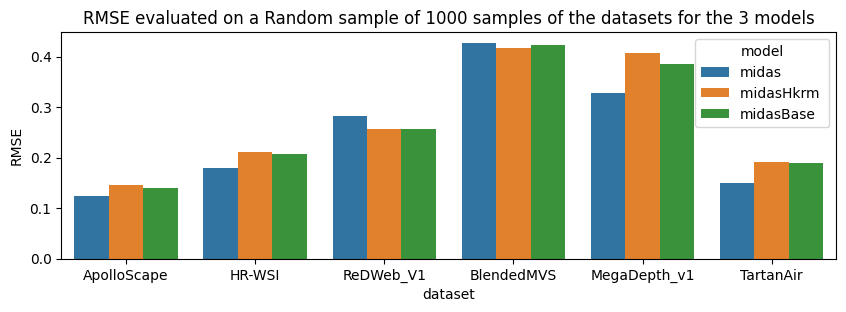

<IPython.core.display.Javascript object>

In [83]:
plt.figure(figsize=(10, 3))
sns.barplot(x="dataset", y="RMSE", hue="model", data=data)
plt.title(
    "RMSE evaluated on a Random sample of 1000 samples of the datasets for the 3 models"
)
plt.savefig("rmse.jpg")
plt.show()

n
n
n
n
x


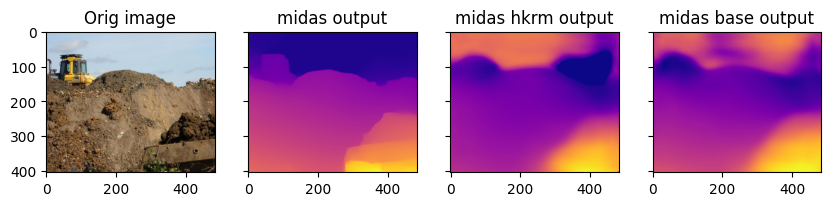

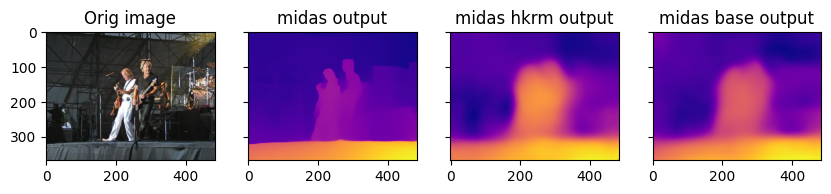

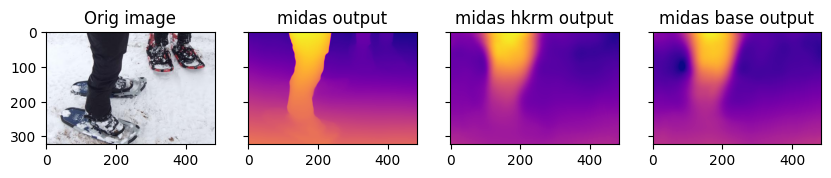

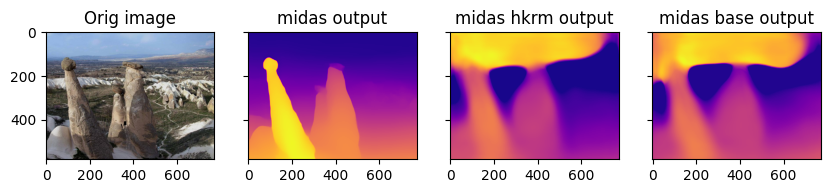

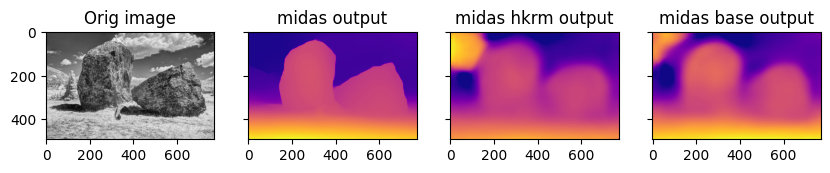

<IPython.core.display.Javascript object>

In [125]:
torch.manual_seed(5)
dataset = RedWeb()
loader = iter(DataLoader(dataset, batch_size=1, collate_fn=lambda x: x, shuffle=True))
for i, batch in enumerate(loader):
    img, disp = batch[0]
    fig, axs = plt.subplots(1, 4, figsize=(10, 10), sharex=True, sharey=True)
    axs[0].imshow(img[:, :, ::-1])
    axs[0].set_title("Orig image")
    axs[1].imshow(predict(midas, img, to_numpy=True))
    axs[1].set_title("midas output")
    axs[2].imshow(predict(midas_hkrm_v4, img, to_numpy=True))
    axs[2].set_title("midas hkrm output")
    axs[3].imshow(predict(midas_base, img, to_numpy=True))
    axs[3].set_title("midas base output")
    fig.savefig(f"example{i}.jpg")
    inp = input()
    if inp == "n":
        continue
    else:
        break

In [84]:
megadepth = MegaDepth()

<IPython.core.display.Javascript object>

In [107]:
img, disp = megadepth[2]

<IPython.core.display.Javascript object>

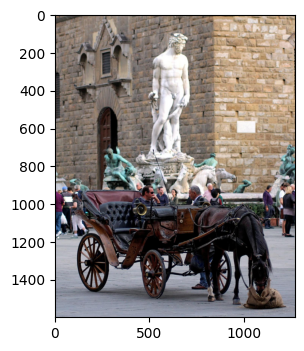

<IPython.core.display.Javascript object>

In [108]:
plt.imshow(img[:, :, ::-1],, )

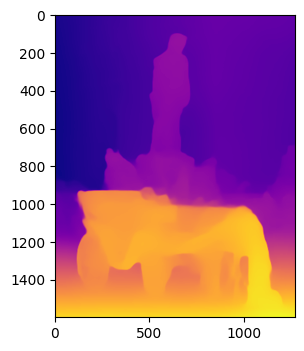

<IPython.core.display.Javascript object>

In [109]:
plt.imshow(predict(midas, img, to_numpy=True))

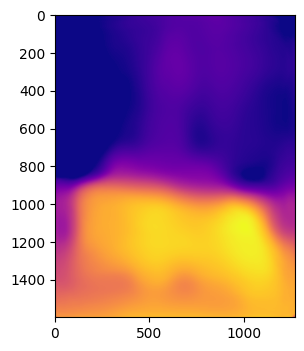

<IPython.core.display.Javascript object>

In [110]:
plt.imshow(predict(midas_hkrm_v4, img, to_numpy=True))

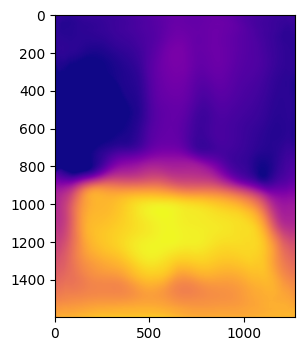

<IPython.core.display.Javascript object>

In [111]:
plt.imshow(predict(midas_base, img, to_numpy=True))